# Code to train models selected from brute force results

In [38]:
## imports 

import sys
import os
sys.path.insert(0, os.path.abspath('../forestpy/forestpy'))

import forest
from importlib import reload
reload(forest)
import os
from pandas import read_csv, DataFrame
import numpy as np

from datetime import datetime, timedelta

from multigrids import TemporalMultiGrid, TemporalGrid
import random_forest_tools as tools
reload(tools)
import matplotlib.pyplot as plt

from scipy import optimize

from matplotlib import rcParams
rcParams["font.family"] = "serif"
rcParams['font.serif'] = ['Times']
rcParams['font.size'] = 14

data_dir = "/Users/rwspicer/Desktop/data/V1/"
feature_file = os.path.join(
    data_dir,
    "master-project/training/ACP/v2/baseline/multigrid/ACP-training-base.yml"
)
label_file = os.path.join(
    data_dir,
    "thermokarst/initiation-regions/ACP/v4/PDM-5var/without_predisp/multigrid/ACP-TKI-PDM5.yml"
)

to_td = lambda x: timedelta(hours = int(x.split(':')[0]),minutes = int(x.split(':')[1]), seconds = float(x.split(':')[2]))
to_seconds = lambda x: int(x.split(':')[0]) *60 *60 + int(x.split(':')[1]) * 60 + float(x.split(':')[2])
to_min = lambda x: to_seconds(x) / 60
to_hour = lambda x: to_min(x) / 60


import pickle
import joblib
from pandas import DataFrame, read_csv

feature_importance_list = []
model_list = []

grid_names = ['fdd', 'tdd', 'tdd+1', 'ewp', 'fwp', 'sp', 'lsp', 'sp+1', 'lat', 'long','aspect','slope', 'elev' ]



def show_feature_importances(model, feature_list, show=False):
    # Get numerical feature importances
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance*100, 3)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    if show:
        [print('{:20} {}%'.format(*pair)) for pair in feature_importances];
        
    feature_importances = {f[0]:f[1] for f in feature_importances} 
    return feature_importances

In [4]:
## load subsampled traing data
# ss_data = pickle.load(open('ss_data.pkl', 'rb'))
ss_data = forest.setup_brute_force(feature_file, label_file)

Loading data.
Creating 25% subsample.
Creating 50% subsample.
Creating 75% subsample.
Formating full data.


In [17]:
## load grid data
training_data = TemporalMultiGrid(feature_file)
om = TemporalGrid(label_file)

list_of_models = [
    'rfm_e2_md2_mfAUTO_msl8_mss5_tdp25.yml',
    
    'rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25.yml',
    'rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml',
    'rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml',
    'rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50.yml',
    'rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50.yml',
    'rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50.yml',
    'rfm_e100_md25_mfAUTO_mln50000_msl4_mss10_tdp25.yml',
    'rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25.yml',
    'rfm_e100_md25_mfAUTO_mln50000_msl2_mss2_tdp25.yml',
    'rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.yml',
    'rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp75.yml',
    'rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75.yml',
]

In [19]:
### this trains and saves all of the models in turn
grades = []
for m in list_of_models:
    print(m)
    settings = forest.RFParams(m)
    tdp = m.split('_')[-1][:-4]
    model = forest.create_model(ss_data[tdp]['features'], ss_data[tdp]['labels'], settings,2,4)
    model_list.append(m)

    l = show_feature_importances(model, grid_names)
    feature_importance_list.append(l)
    
    predicted = model.predict(ss_data['full']['features'].T)
    
    diff = predicted - ss_data['full']['labels']

    mean_error = np.nanmean(diff)
    median_error = np.nanmedian(diff)
    var_error = np.nanvar(diff)

     
    mean_abs_error = np.abs(diff).mean()
    median_abs_error = np.nanmedian(np.abs(diff))
    var_abs_error = np.nanvar(np.abs(diff))
    
    r2 =  model.score(ss_data['full']['features'].T, ss_data['full']['labels'])

   
    joblib.dump(model,  '/Volumes/toshi-stati/tk-rf-models/baseline-models/' + m.split('.')[0]+'.joblib') 
    
    grades.append({
        "name":m, 
#         "time": str(total), 
        "mean error": mean_error, 
        "median error": median_error, 
        "var error": var_error,
        "mean abs error": mean_abs_error, 
        "medain abs error":median_abs_error, 
        "var abs error": var_abs_error,
         "r^2": r2
    })
    print(grades[-1])

rfm_e2_md2_mfAUTO_msl8_mss5_tdp25.yml
building tree 1 of 2
building tree 2 of 2


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished


{'name': 'rfm_e2_md2_mfAUTO_msl8_mss5_tdp25.yml', 'mean error': -0.00437062246003456, 'median error': 1.5838377794601168, 'var error': 174.44483470987242, 'mean abs error': 9.723942608510526, 'medain abs error': 7.262862482908471, 'var abs error': 79.88979395860704, 'r^2': 0.0884681738990929}
rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25.yml
building tree 1 of 50building tree 2 of 50
building tree 3 of 50building tree 4 of 50




[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 34.2min


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 48.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   50.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   50.0s finished


{'name': 'rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25.yml', 'mean error': -0.007464986976276566, 'median error': 0.02365385002117648, 'var error': 4.615954712581808, 'mean abs error': 1.341482457655878, 'medain abs error': 0.8348587595797274, 'var abs error': 2.816435254413921, 'r^2': 0.9758798248703935}
rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50building tree 3 of 50
building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50building tree 19 of 50

building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 33.8min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 48.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   49.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   49.7s finished


{'name': 'rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml', 'mean error': -0.008045791654176638, 'median error': 0.021079827694041153, 'var error': 4.389398517460266, 'mean abs error': 1.3392879817097583, 'medain abs error': 0.8496079581569154, 'var abs error': 2.59577095427141, 'r^2': 0.9770636085475507}
rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50building tree 3 of 50
building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 34.0min


building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 48.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   48.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   51.2s finished


{'name': 'rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml', 'mean error': -0.008045791654176664, 'median error': 0.021079827694041153, 'var error': 4.3893985174602665, 'mean abs error': 1.3392879817097583, 'medain abs error': 0.8496079581569145, 'var abs error': 2.59577095427141, 'r^2': 0.9770636085475507}
rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10building tree 2 of 10building tree 3 of 10
building tree 4 of 10


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10building tree 8 of 10

building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 23.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.8s finished


{'name': 'rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50.yml', 'mean error': -0.004427834581431149, 'median error': 0.01868227564940117, 'var error': 4.34889588738229, 'mean abs error': 1.3417555286894307, 'medain abs error': 0.8500910661760559, 'var abs error': 2.548607594332691, 'r^2': 0.9772754839460465}
rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10building tree 2 of 10building tree 3 of 10
building tree 4 of 10


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 23.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.8s finished


{'name': 'rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50.yml', 'mean error': -0.004427834581431149, 'median error': 0.01868227564940117, 'var error': 4.34889588738229, 'mean abs error': 1.3417555286894307, 'medain abs error': 0.8500910661760559, 'var abs error': 2.548607594332691, 'r^2': 0.9772754839460465}
rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 23.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.6s finished


{'name': 'rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50.yml', 'mean error': -0.004807347564471678, 'median error': 0.017919513982595614, 'var error': 4.271177324726871, 'mean abs error': 1.3437074405269829, 'medain abs error': 0.8582148153413963, 'var abs error': 2.4656507495899023, 'r^2': 0.9776815707235536}
rfm_e100_md25_mfAUTO_mln50000_msl4_mss10_tdp25.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 32.8min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 92.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.4min finished


{'name': 'rfm_e100_md25_mfAUTO_mln50000_msl4_mss10_tdp25.yml', 'mean error': -0.007017828570165114, 'median error': 0.03898239281383409, 'var error': 9.706678741638736, 'mean abs error': 1.8139365792471882, 'medain abs error': 0.9088986655274341, 'var abs error': 6.416362078025571, 'r^2': 0.949279148692268}
rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 33.6min


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 92.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.5min finished


{'name': 'rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25.yml', 'mean error': -0.007150212402069312, 'median error': 0.03813790740251255, 'var error': 9.591748281016578, 'mean abs error': 1.8124318660581265, 'medain abs error': 0.9202476983491616, 'var abs error': 6.3068901374510284, 'r^2': 0.9498796884082252}
rfm_e100_md25_mfAUTO_mln50000_msl2_mss2_tdp25.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 32.8min


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 92.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.5min finished


{'name': 'rfm_e100_md25_mfAUTO_mln50000_msl2_mss2_tdp25.yml', 'mean error': -0.007182809244814067, 'median error': 0.03813044811495736, 'var error': 9.590758573651724, 'mean abs error': 1.8126828019974148, 'medain abs error': 0.9207775070022546, 'var abs error': 6.304991225743191, 'r^2': 0.9498848575138996}
rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 117.9min


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 169.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   34.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   49.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   34.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   48.5s finished


{'name': 'rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.yml', 'mean error': -0.004368479385892236, 'median error': 0.018465224546789116, 'var error': 3.8081734717117612, 'mean abs error': 1.2865636172230153, 'medain abs error': 0.8332191827891542, 'var abs error': 2.152946614161946, 'r^2': 0.9801009394187401}
rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp75.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50building tree 3 of 50
building tree 4 of 50


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 120.5min


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 172.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   34.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   50.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   51.7s finished


{'name': 'rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp75.yml', 'mean error': -0.004368479385892228, 'median error': 0.018465224546789116, 'var error': 3.8081734717117612, 'mean abs error': 1.2865636172230153, 'medain abs error': 0.8332191827891542, 'var abs error': 2.1529466141619458, 'r^2': 0.98010093941874}
rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75.yml


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 120.6min


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 174.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   47.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   39.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   55.5s finished


{'name': 'rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75.yml', 'mean error': -0.004531831897772444, 'median error': 0.01747778585711557, 'var error': 3.7830136804499968, 'mean abs error': 1.2928694254273305, 'medain abs error': 0.8414277746916001, 'var abs error': 2.111522866745576, 'r^2': 0.9802324000190766}


In [30]:
DataFrame(grades)[1:].to_csv('../results/baseline_v1_stats.csv', index=False)

In [63]:
grades_DF = read_csv('../results/baseline_v1_stats.csv', index_col=0)

In [62]:
grades_DF['time'] = ''
grades_DF['time']['rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25.yml'] = 48.6
grades_DF['time']['rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml'] = 48.3
grades_DF['time']['rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml'] = 48.7
grades_DF['time']['rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50.yml'] = 23.7
grades_DF['time']['rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50.yml'] = 23.9
grades_DF['time']['rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50.yml'] = 23.9
grades_DF['time']['rfm_e100_md25_mfAUTO_mln50000_msl4_mss10_tdp25.yml'] = 92.5
grades_DF['time']['rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25.yml'] = 92.6
grades_DF['time']['rfm_e100_md25_mfAUTO_mln50000_msl2_mss2_tdp25.yml'] = 92.6
grades_DF['time']['rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.yml'] = 169.4
grades_DF['time']['rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp75.yml'] = 172.4
grades_DF['time']['rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75.yml']= 174.2

grades_DF.to_csv('../results/baseline_v1_stats.csv')

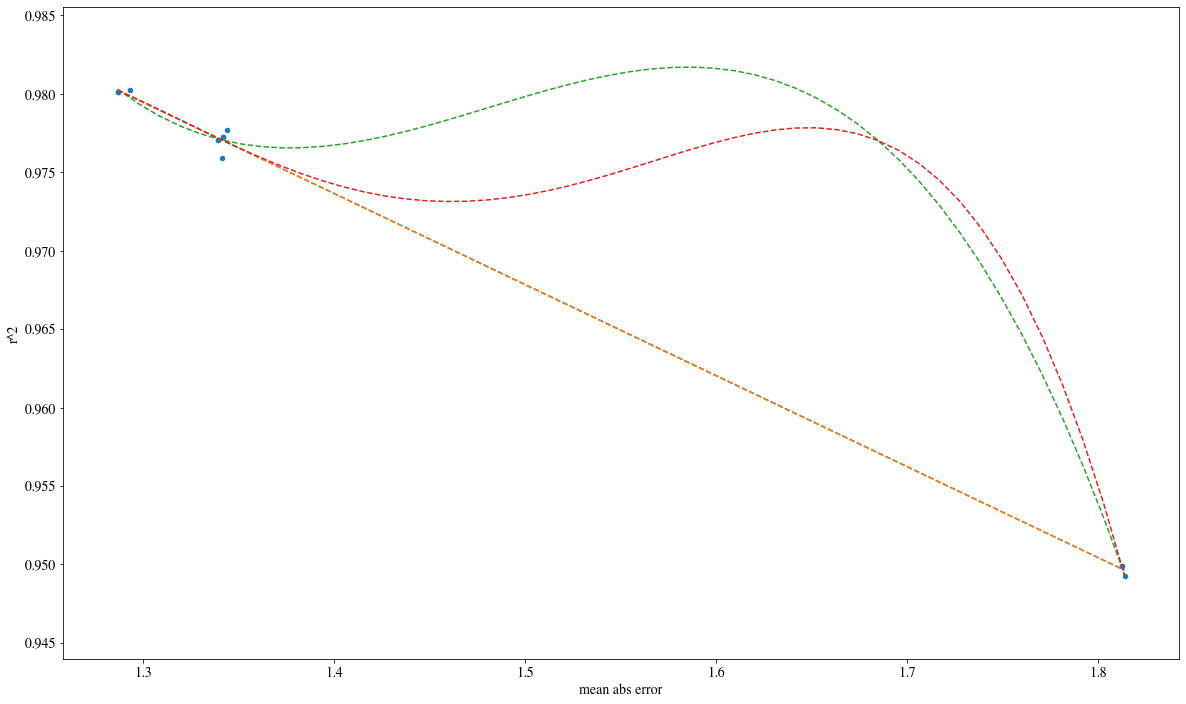

In [60]:
x_col = 'mean abs error'
y_col = 'r^2'

fig, ax = plt.subplots(figsize = (20, 12))
grades_DF.plot.scatter(x=x_col, y = y_col, ax = ax)

x_data = grades_DF[x_col]
y_data = grades_DF[y_col]
#curve = lambda  x, a,b,c: a * np.exp(-b * x) + c
linear = lambda  x, m, b: m*x + b
second = lambda x, a,b,c: a*x*x + b*x +c
third = lambda x, a,b,c, d: a*x*x*x + b*x*x + c*x +d 
fourth = lambda x, a,b,c, d, e: a*x*x*x*x + b*x*x*x + c*x*x +d*x +e

for f in [linear,second,third, fourth]:
    curve = f
    popt, pcov = optimize.curve_fit(curve, x_data, y_data)
    nx_data = np.linspace(x_data.min(), x_data.max(), 50)
    ax.plot(nx_data, curve(nx_data, *popt), linestyle='--')#, 'g--')

In [77]:
e = [forest.RFParams(i)['estimators'] for i in grades_DF.index]

grades_DF['e']= e

grades_DF['time per tree'] = (grades_DF['time'] / 4) / grades_DF['e']

In [78]:
grades_DF

,mean error,median error,var error,mean abs error,medain abs error,var abs error,r^2,time,e,time per tree
name,,,,,,,,,,
rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25.yml,-0.007465,0.023654,4.615955,1.341482,0.834859,2.816435,0.975880,48.6,50,0.24300
rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml,-0.008046,0.021080,4.389399,1.339288,0.849608,2.595771,0.977064,48.7,50,0.24350
rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml,-0.008046,0.021080,4.389399,1.339288,0.849608,2.595771,0.977064,48.7,50,0.24350
rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50.yml,-0.004428,0.018682,4.348896,1.341756,0.850091,2.548608,0.977275,23.7,10,0.59250
rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50.yml,-0.004428,0.018682,4.348896,1.341756,0.850091,2.548608,0.977275,23.9,10,0.59750
rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50.yml,-0.004807,0.017920,4.271177,1.343707,0.858215,2.465651,0.977682,23.9,10,0.59750
rfm_e100_md25_mfAUTO_mln50000_msl4_mss10_tdp25.yml,-0.007018,0.038982,9.706679,1.813937,0.908899,6.416362,0.949279,92.5,100,0.23125
rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25.yml,-0.007150,0.038138,9.591748,1.812432,0.920248,6.306890,0.949880,92.6,100,0.23150
rfm_e100_md25_mfAUTO_mln50000_msl2_mss2_tdp25.yml,-0.007183,0.038130,9.590759,1.812683,0.920778,6.304991,0.949885,92.6,100,0.23150


[ 13.36508985 -12.49454183]
[59.2585489 26.7280108]


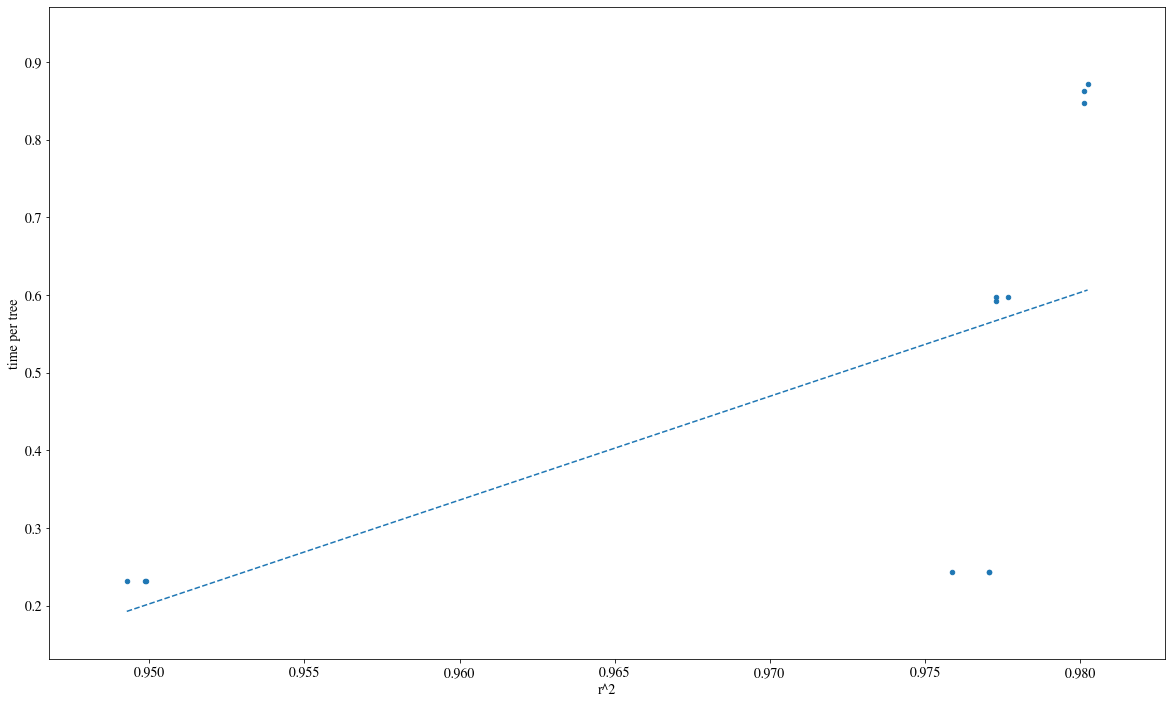

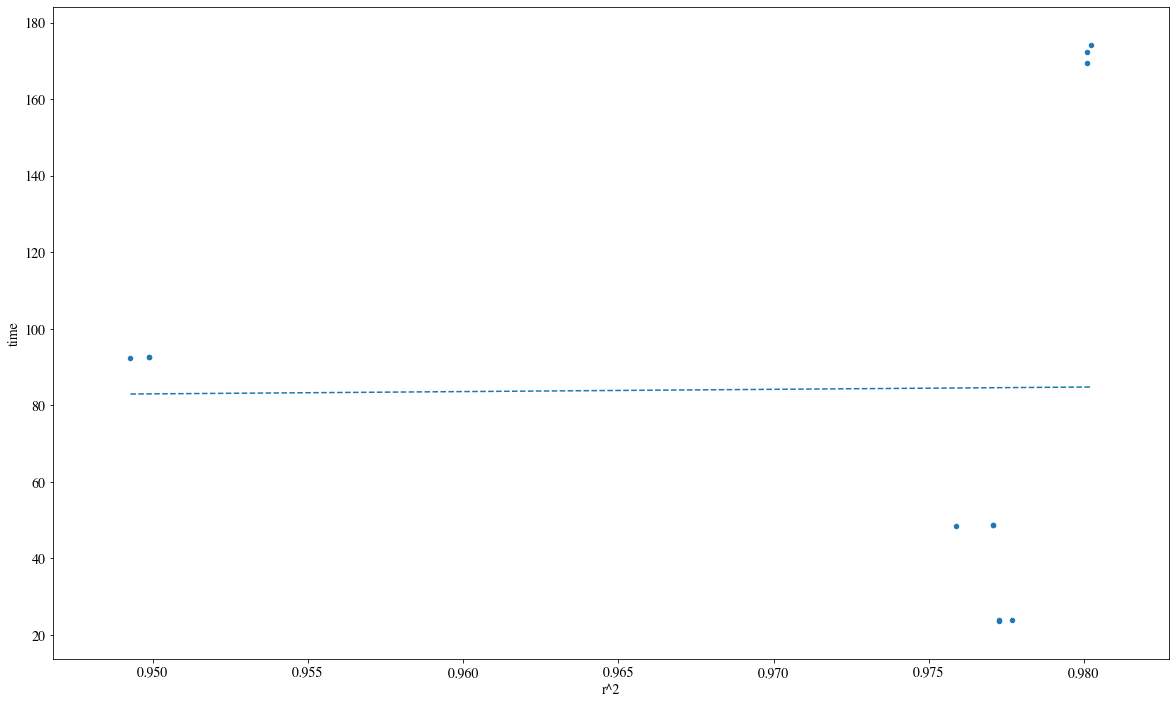

In [102]:
x_col = 'r^2'
y_col = 'time per tree'

fig, ax = plt.subplots(figsize = (20, 12))
grades_DF.plot.scatter(x=x_col, y = y_col, ax = ax)

x_min = grades_DF[x_col].min()
x_max = grades_DF[x_col].max()

y_min = grades_DF[y_col].min()
y_max = grades_DF[y_col].max()

x_buffer = .0025
y_buffer = .1
ax.axis([x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

x_data = grades_DF[x_col]
y_data = grades_DF[y_col]
#curve = lambda  x, a,b,c: a * np.exp(-b * x) + c
linear = lambda  x, m, b: m*x + b
second = lambda x, a,b,c: a*x*x + b*x +c
third = lambda x, a,b,c, d: a*x*x*x + b*x*x + c*x +d 
fourth = lambda x, a,b,c, d, e: a*x*x*x*x + b*x*x*x + c*x*x +d*x +e

for f in [linear]:#,second,third, fourth]:
    curve = f
    popt, pcov = optimize.curve_fit(curve, x_data, y_data)
    nx_data = np.linspace(x_data.min(), x_data.max(), 50)
    ax.plot(nx_data, curve(nx_data, *popt), linestyle='--')#, 'g--')
    print(popt)
    
    
x_col = 'r^2'
y_col = 'time'

fig, ax = plt.subplots(figsize = (20, 12))
grades_DF.plot.scatter(x=x_col, y = y_col, ax = ax)

x_min = grades_DF[x_col].min()
x_max = grades_DF[x_col].max()

y_min = grades_DF[y_col].min()
y_max = grades_DF[y_col].max()

x_buffer = .0025
y_buffer = 10
ax.axis([x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

x_data = grades_DF[x_col]
y_data = grades_DF[y_col]
#curve = lambda  x, a,b,c: a * np.exp(-b * x) + c
linear = lambda  x, m, b: m*x + b
second = lambda x, a,b,c: a*x*x + b*x +c
third = lambda x, a,b,c, d: a*x*x*x + b*x*x + c*x +d 
fourth = lambda x, a,b,c, d, e: a*x*x*x*x + b*x*x*x + c*x*x +d*x +e

for f in [linear]:#,second,third, fourth]:
    curve = f
    popt, pcov = optimize.curve_fit(curve, x_data, y_data)
    nx_data = np.linspace(x_data.min(), x_data.max(), 50)
    ax.plot(nx_data, curve(nx_data, *popt), linestyle='--')#, 'g--')
    print(popt)

In [104]:
grades_DF.sort_values('mean abs error')

,mean error,median error,var error,mean abs error,medain abs error,var abs error,r^2,time,e,time per tree
name,,,,,,,,,,
rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.yml,-0.004368,0.018465,3.808173,1.286564,0.833219,2.152947,0.980101,169.4,50,0.84700
rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp75.yml,-0.004368,0.018465,3.808173,1.286564,0.833219,2.152947,0.980101,172.4,50,0.86200
rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75.yml,-0.004532,0.017478,3.783014,1.292869,0.841428,2.111523,0.980232,174.2,50,0.87100
rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml,-0.008046,0.021080,4.389399,1.339288,0.849608,2.595771,0.977064,48.7,50,0.24350
rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml,-0.008046,0.021080,4.389399,1.339288,0.849608,2.595771,0.977064,48.7,50,0.24350
rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25.yml,-0.007465,0.023654,4.615955,1.341482,0.834859,2.816435,0.975880,48.6,50,0.24300
rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50.yml,-0.004428,0.018682,4.348896,1.341756,0.850091,2.548608,0.977275,23.7,10,0.59250
rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50.yml,-0.004428,0.018682,4.348896,1.341756,0.850091,2.548608,0.977275,23.9,10,0.59750
rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50.yml,-0.004807,0.017920,4.271177,1.343707,0.858215,2.465651,0.977682,23.9,10,0.59750


In [ ]:
# rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75.yml
# rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.yml

In [105]:
def evaulte_model_statistically(model_file, om, year, model_name = ''):
    """
    """
    
    if type(model_file) is str:
        clf = joblib.load(model_file)
    else: 
        clf = model_file
        
    ov = clf.verbose
    clf.verbose = 0 
    new = tools.apply_model_to_year(clf, training_data, year, training_data.config['mask'])

#     tools.quick_coolwarm(om[year] , 'original model ' + str(year))
#     tools.quick_coolwarm(new , model_name + ' '+ str(year))

    
    diff = (new -om[year])
#     tools.to_figure(diff , '',  'comparison ' + str(year),cmap = 'coolwarm', vmin=-10,vmax=10, save=False)

    stats = {
        'min diff': np.nanmin(diff), 
        'max diff': np.nanmax(diff),
        'mean diff': np.nanmean(diff),
        'abs mean diff': np.nanmean(np.abs(diff)),
        'max abs diff': np.nanmax(np.abs(diff)),
        'min abs diff': np.nanmin(np.abs(diff)),
        'min predict':np.nanmin(new),
        'max predict':np.nanmax(new), 
    }
    clf.verbose = ov
    return stats

def evaulte_model_pictorially(model_file, om, year, model_name = ''):
    """
    """
    import pprint
    if type(model_file) is str:
        clf = joblib.load(model_file)
    else: 
        clf = model_file
        
    ov = clf.verbose
    clf.verbose = 0
    new = tools.apply_model_to_year(clf, training_data, year, training_data.config['mask'])

#     tools.quick_coolwarm(om[year] , 'original model ' + str(year))
#     tools.quick_coolwarm(new , model_name + ' '+ str(year))

    tools.to_figure(om[year] , 'original model ' + str(year),cmap = 'coolwarm', vmin=-40,vmax=40, save=False)
    tools.to_figure(new , model_name + ' '+ str(year),cmap = 'coolwarm', vmin=-40,vmax=40, save=False)



    
    diff = (new -om[year])
    tools.to_figure(diff , '',  'comparison ' + str(year),cmap = 'coolwarm', vmin=-10,vmax=10, save=False)

    stats = evaulte_model_statistically(clf, om, year, model_name)
    pprint.pprint(stats)
    
#     print ('min diff:', np.nanmin(diff), 'max diff:', np.nanmax(diff))
#     print ('mean diff:', np.nanmean(diff), 'abs mean diff:', np.nanmean(np.abs(diff)))
    clf.verbose = ov
    return clf



[]